Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 2017/2018  
http://www.fer.unizg.hr/predmet/su

------------------------------

### Laboratorijska vježba 3: Stroj potpornih vektora i algoritam k-najbližih susjeda

*Verzija: 0.3  
Zadnji put ažurirano: 13. studenog 2017.*

(c) 2015-2017 Jan Šnajder, Domagoj Alagić  

Objavljeno: **13. studenog 2017.**  
Rok za predaju: **4. prosinca 2017. u 07:00h**

------------------------------

### Upute

Treća laboratorijska vježba sastoji se od sedam zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import mlutils
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1. Klasifikator stroja potpornih vektora (SVM)

#### (a)

Upoznajte se s razredom [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), koja ustvari implementira sučelje prema implementaciji [`libsvm`](http://www.csie.ntu.edu.tw/~cjlin/libsvm/). Primijenite model `SVC` s linearnom jezgrenom funkcijom (tj. bez preslikavanja primjera u prostor značajki) na skup podataka `seven` (dan niže) s $N=7$ primjera. Ispišite koeficijente $w_0$ i $\mathbf{w}$. Ispišite dualne koeficijente i potporne vektore. Završno, koristeći funkciju `mlutils.plot_2d_svc_problem` iscrtajte podatke, decizijsku granicu i marginu. Funkcija prima podatke, oznake i klasifikator (objekt klase `SVC`). 

Izračunajte širinu dobivene margine (prisjetite se geometrije linearnih modela).

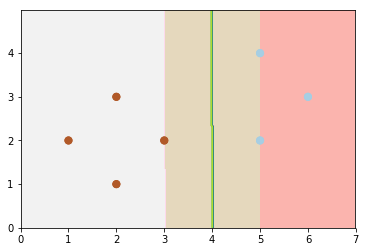

In [41]:
from sklearn.svm import SVC

seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, -1, -1, -1])

model = SVC(kernel='linear').fit(seven_X, seven_y)
mlutils.plot_2d_svc_problem(seven_X, seven_y, svc=model)

In [42]:
np.dot(model.support_vectors_, model.coef_.T) + model.coef0

array([[-4.99912109],
       [-4.99970703],
       [-2.99970703]])

In [43]:
print('Support vectors:')
print(model.support_vectors_)

Support vectors:
[[5. 2.]
 [5. 4.]
 [3. 2.]]


In [44]:
nl = '\n'
print(
  'dual  = ', model.dual_coef_, nl,
  'w0, w = ', model.coef0, '  |  ', model.coef_, nl,
  'width = ', 2 / np.linalg.norm(model.coef_),
  sep='')

dual  = [[-4.99707031e-01 -1.46484375e-04  4.99853516e-01]]
w0, w = 0.0  |  [[-9.99707031e-01 -2.92968750e-04]]
width = 2.000586023305519


**Q:** Koliko iznosi širina margine i zašto?  
**Q:** Koji primjeri su potporni vektori i zašto?

#### (b)

Definirajte funkciju `hinge(model, x, y)` koja izračunava gubitak zglobnice modela SVM na primjeru `x`. Izračunajte gubitke modela naučenog na skupu `seven` za primjere $\mathbf{x}^{(2)}=(3,2)$ i $\mathbf{x}^{(1)}=(3.5,2)$ koji su označeni pozitivno ($y=1$) te za $\mathbf{x}^{(3)}=(4,2)$ koji je označen negativno ($y=-1$). Također, izračunajte prosječni gubitak SVM-a na skupu `seven`. Uvjerite se da je rezultat identičan onome koji biste dobili primjenom ugrađene funkcije [`metrics.hinge_loss`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html).

In [45]:
from sklearn.metrics import hinge_loss

def hinge(model, x, y):
  x = np.reshape(x, (1, np.shape(x)[0]))
  y = np.reshape(y, (1,))
  loss = 1 - model.decision_function(x) * y
  return np.clip(loss, 0, None)

seven_test = [((3,2), 1), ((3.5, 2), 1), ((4,2), -1)]
for x, y in seven_test:
  print(f'Hinge({x[0]:.1f}, {x[1]:.1f})  ', hinge(model, x, y))

Hinge(3.0, 2.0)   [0.00019531]
Hinge(3.5, 2.0)   [0.50004883]
Hinge(4.0, 2.0)   [1.00009766]


In [46]:
sk_loss = hinge_loss(
  [x[1] for x in seven_test], 
  model.decision_function([x[0] for x in seven_test]))
my_loss = np.average([hinge(model, x, y) for x, y in seven_test])

print(sk_loss, my_loss)
print(sk_loss == my_loss)

0.5001139322916662 0.5001139322916662
True


#### (c)

Vratit ćemo se na skupove podataka `outlier` ($N=8$) i `unsep` ($N=8$) iz prošle laboratorijske vježbe (dani niže) i pogledati kako se model SVM-a nosi s njima. Naučite ugrađeni model SVM-a (s linearnom jezgrom) na ovim podatcima i iscrtajte decizijsku granicu (skupa s marginom). Također ispišite točnost modela korištenjem funkcije [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

In [47]:
from sklearn.metrics import accuracy_score

outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, -1)

unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, -1)

Acc: 1.0


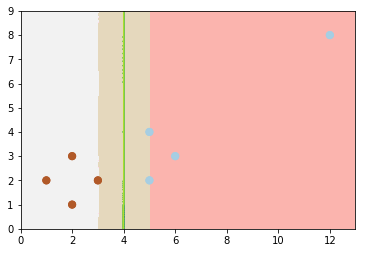

In [48]:
model = SVC(kernel='linear')
model.fit(outlier_X, outlier_y)
print('Acc:', accuracy_score(outlier_y, model.predict(outlier_X)))
mlutils.plot_2d_svc_problem(outlier_X, outlier_y, model)

Acc: 0.875


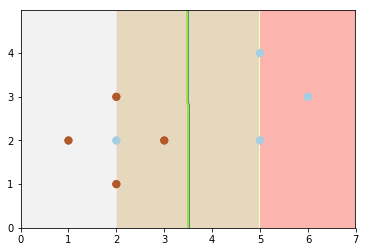

In [49]:
model = SVC(kernel='linear')
model.fit(unsep_X, unsep_y)
print('Acc:', accuracy_score(unsep_y, model.predict(unsep_X)))
mlutils.plot_2d_svc_problem(unsep_X, unsep_y, model)

**Q:** Kako stršeća vrijednost utječe na SVM?  
**Q:** Kako se linearan SVM nosi s linearno neodvojivim skupom podataka?

### 2. Nelinearan SVM

Ovaj zadatak pokazat će kako odabir jezgre utječe na kapacitet SVM-a. Na skupu `unsep` iz prošlog zadatka trenirajte tri modela SVM-a s različitim jezgrenim funkcijama: linearnom, polinomijalnom i radijalnom baznom (RBF) funkcijom. Varirajte hiperparametar $C$ po vrijednostima $C\in\{10^{-2},1,10^2\}$, dok za ostale hiperparametre (stupanj polinoma za polinomijalnu jezgru odnosno hiperparametar $\gamma$ za jezgru RBF) koristite podrazumijevane vrijednosti. Prikažite granice između klasa (i margine) na grafikonu organiziranome u polje $3x3$, gdje su stupci različite jezgre, a retci različite vrijednosti parametra $C$.

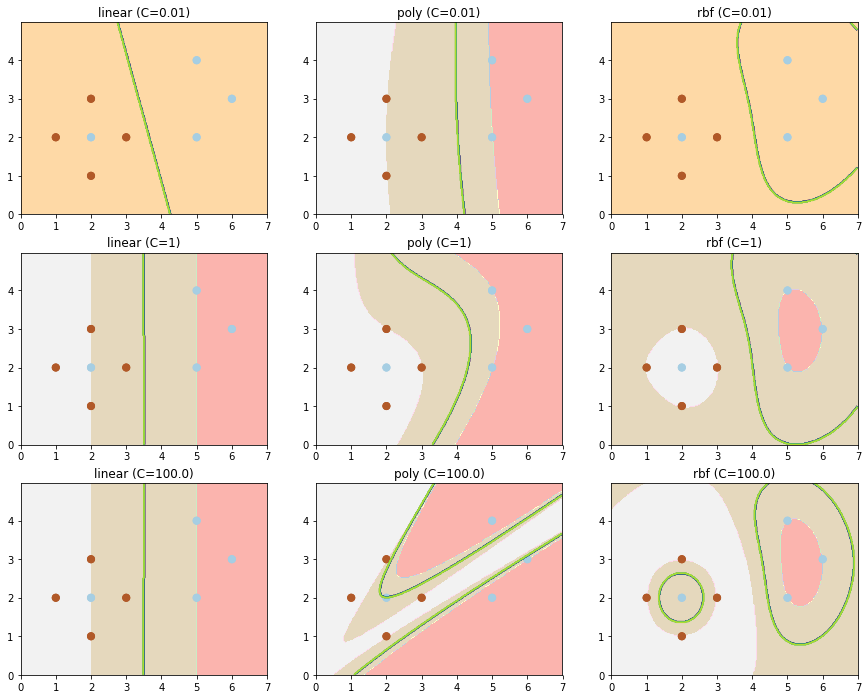

In [40]:
subplot_index = 1
plt.figure(figsize=(15, 12))
for C in (1e-2, 1, 1e2):
  for k in ('linear', 'poly', 'rbf'):
    model = SVC(kernel=k, C=C).fit(unsep_X, unsep_y)
    plt.subplot(3, 3, subplot_index)
    plt.title(f'{k} (C={C})')
    mlutils.plot_2d_svc_problem(unsep_X, unsep_y, svc=model)
    subplot_index += 1

### 3. Optimizacija hiperparametara SVM-a

Pored hiperparametra $C$, model SVM s jezgrenom funkcijom RBF ima i dodatni hiperparametar $\gamma=\frac{1}{2\sigma^2}$ (preciznost). Taj parametar također određuje složenost modela: velika vrijednost za $\gamma$ znači da će RBF biti uska, primjeri će biti preslikani u prostor u kojem su (prema skalarnome produktu) međusobno vrlo različiti, što će rezultirati složenijim modelima. Obrnuto, mala vrijednost za $\gamma$ znači da će RBF biti široka, primjeri će biti međusobno sličniji, što će rezultirati jednostavnijim modelima. To ujedno znači da, ako odabremo veći $\gamma$, trebamo jače regularizirati model, tj. trebamo odabrati manji $C$, kako bismo spriječili prenaučenost. Zbog toga je potrebno zajednički optimirati hiperparametre $C$ i $\gamma$, što se tipično radi iscrpnim pretraživanjem po rešetci (engl. *grid search*). Ovakav pristup primjenjuje se kod svih modela koji sadrže više od jednog hiperparametra.


#### (a)

Definirajte funkciju 

> `grid_search(X_train, X_validate, y_train, y_validate, c_range=(c1,c2), g_range=(g1,g2), error_surface=False)` 

koja optimizira parametre $C$ i $\gamma$ pretraživanjem po rešetci. Funkcija treba pretražiti hiperparametre $C\in\{2^{c_1},2^{c_1+1},\dots,2^{c_2}\}$ i $\gamma\in\{2^{g_1},2^{g_1+1},\dots,2^{g_2}\}$. Funkcija treba vratiti optimalne hiperparametre $(C^*,\gamma^*)$, tj. one za koje na skupu za provjeru model ostvaruju najmanju pogrešku. Dodatno, ako je `surface=True`, funkcija treba vratiti matrice (tipa `ndarray`) pogreške modela (očekivanje gubitka 0-1) na skupu za učenje i skupu za provjeru. Svaka je matrica dimenzija $(c_2-c_1+1)\times(g_2-g_1+1)$ (retci odgovaraju različitim vrijednostima za $C$, a stupci različitim vrijednostima za $\gamma$).

In [137]:
from sklearn.metrics import accuracy_score, zero_one_loss
import itertools as it

def grid_search(
    X_train, X_validate, y_train, y_validate, c_range=(0,5), 
    g_range=(0,5), error_surface=False):
  c0, c1, g0, g1 = *c_range, *g_range
  results_train = np.zeros((c1 - c0 + 1, g1 - g0 + 1))
  results_test = np.zeros_like(results_train)
  cmin, gmin, emin = None, None, np.inf
  for c, g in it.product(range(c0, c1 + 1), range(g0, g1 + 1)):
    cval, gval = 2**c, 2**g
    model = SVC(C=cval, gamma=gval).fit(X_train, y_train)
    error_test = zero_one_loss(y_validate, model.predict(X_validate))
    if error_surface:
      error_train = zero_one_loss(y_train, model.predict(X_train))
      results_train[c - c0, g - g0] = error_train
      results_test[c - c0, g - g0] = error_test
    if error_test < emin:
      cmin, gmin, emin = cval, gval, error_test
  return (cmin, gmin, results_train, results_test) \
    if error_surface else (cmin, gmin)

#### (b)

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte **dva** skupa podataka od $N=200$ primjera: jedan s $n=2$ dimenzije i drugi s $n=1000$ dimenzija. Primjeri neka dolaze iz dviju klasa, s time da svakoj klasi odgovaraju dvije grupe (`n_clusters_per_class=2`), kako bi problem bio nešto složeniji, tj. nelinearniji. Neka sve značajke budu informativne. Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1.

Na oba skupa optimirajte SVM s jezgrenom funkcijom RBF, u rešetci $C\in\{2^{-5},2^{-4},\dots,2^{15}\}$ i $\gamma\in\{2^{-15},2^{-14},\dots,2^{3}\}$. Prikažite površinu pogreške modela na skupu za učenje i skupu za provjeru, i to na oba skupa podataka (ukupno četiri grafikona) te ispišite optimalne kombinacije hiperparametara. Za prikaz površine pogreške modela možete koristiti funkciju `mlutils.plot_error_surface`.

In [138]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [139]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
  *make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=2))

X2_train, X2_test, y2_train, y2_test = train_test_split(
  *make_classification(
    n_samples=200,
    n_features=1000,
    n_informative=1000,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=2))

In [140]:
cmin, gmin, error_train, error_test = grid_search(
  X1_train, X1_test, y1_train, y1_test, error_surface=True,
  c_range=(-5, 15), g_range=(-15, 3))
print('Optimal params: c=%s, g=%s' % (cmin, gmin))

Optimal params: c=0.125, g=2


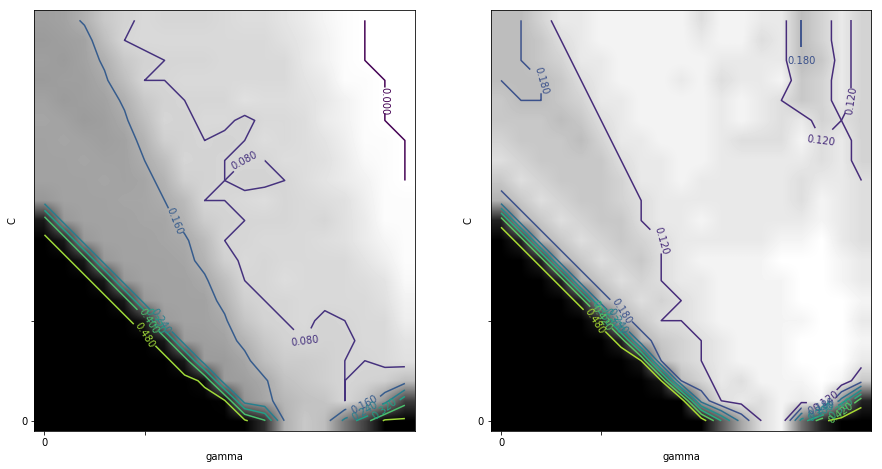

In [141]:
plt.figure(figsize=(15, 12))

plt.subplot(1, 2, 1)
mlutils.plot_error_surface(error_train)

plt.subplot(1, 2, 2)
mlutils.plot_error_surface(error_test)

In [142]:
cmin, gmin, error_train, error_test = grid_search(
  X2_train, X2_test, y2_train, y2_test, error_surface=True,
  c_range=(-5, 15), g_range=(-15, 3))
print('Optimal params: c=%s, g=%s' % (cmin, gmin))

Optimal params: c=0.03125, g=3.0517578125e-05


/usr/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


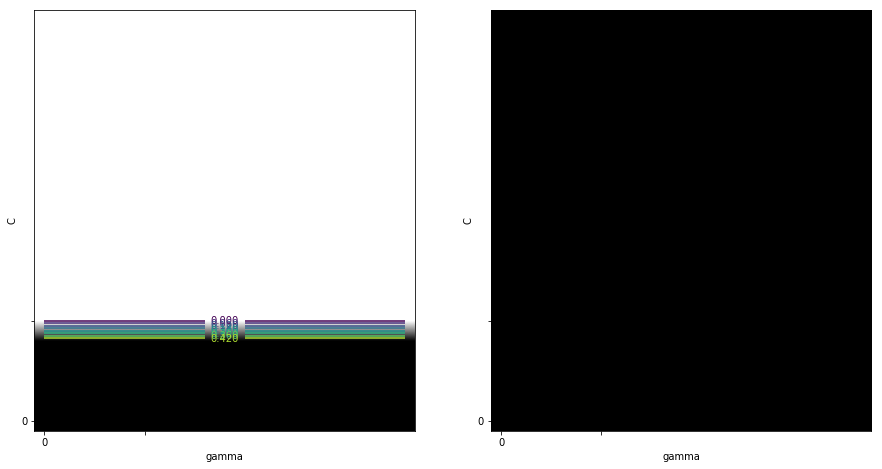

In [143]:
plt.figure(figsize=(15, 12))

plt.subplot(1, 2, 1)
mlutils.plot_error_surface(error_train)

plt.subplot(1, 2, 2)
mlutils.plot_error_surface(error_test)

**Q:** Razlikuje li se površina pogreške na skupu za učenje i skupu za ispitivanje? Zašto?  
**Q:** U prikazu površine pogreške, koji dio površine odgovara prenaučenosti, a koji podnaučenosti? Zašto?  
**Q:** Kako broj dimenzija $n$ utječe na površinu pogreške, odnosno na optimalne hiperparametre $(C^*, \gamma^*)$?  
**Q:** Preporuka je da povećanje vrijednosti za $\gamma$ treba biti popraćeno smanjenjem vrijednosti za $C$. Govore li vaši rezultati u prilog toj preporuci? Obrazložite.  

### 4. Utjecaj standardizacije značajki kod SVM-a

U prvoj laboratorijskoj vježbi smo pokazali kako značajke različitih skala mogu onemogućiti interpretaciju naučenog modela linearne regresije. Međutim, ovaj problem javlja se kod mnogih modela pa je tako skoro uvijek bitno prije treniranja skalirati značajke, kako bi se spriječilo da značajke s većim numeričkim rasponima dominiraju nad onima s manjim numeričkim rasponima. To vrijedi i za SVM, kod kojega skaliranje nerijetko može znatno poboljšati rezultate. Svrha ovog zadataka jest eksperimentalno utvrditi utjecaj skaliranja značajki na točnost SVM-a.

Generirat ćemo dvoklasni skup od $N=500$ primjera s $n=2$ značajke, tako da je dimenzija $x_1$ većeg iznosa i većeg raspona od dimenzije $x_0$, te ćemo dodati jedan primjer koji vrijednošću značajke $x_1$ odskače od ostalih primjera:

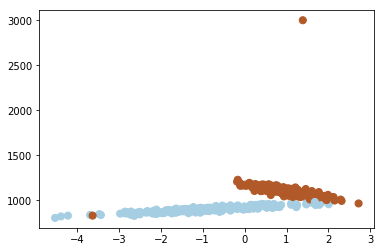

In [88]:
from sklearn.datasets import make_classification

X, y = make_classification(
  n_samples=500,
  n_features=2,
  n_classes=2,
  n_redundant=0,
  n_clusters_per_class=1,
  random_state=69)
X[:,1] = X[:,1]*100+1000
X[0,1] = 3000

mlutils.plot_2d_svc_problem(X, y)

#### (a)

Proučite funkciju za iscrtavanje histograma [`hist`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ (ovdje i u sljedećim zadatcima koristite `bins=50`).

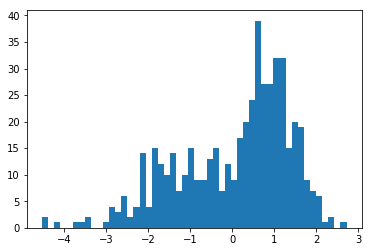

In [89]:
hist(X[:, 0], bins=50)
plt.show()

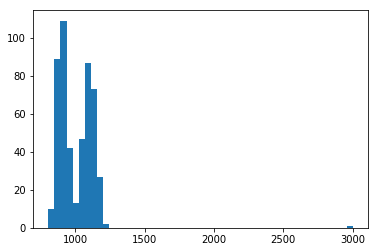

In [90]:
hist(X[:, 1], bins=50)
plt.show()

#### (b)

Proučite razred [`preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ ako su iste skalirane min-max skaliranjem (ukupno dva histograma).

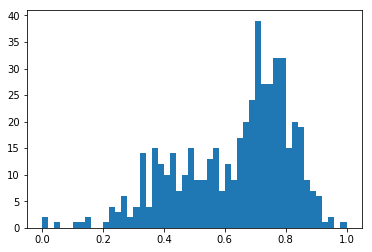

In [91]:
from sklearn.preprocessing import MinMaxScaler
Xnorm = MinMaxScaler().fit_transform(X)

hist(Xnorm[:, 0], bins=50)
plt.show()

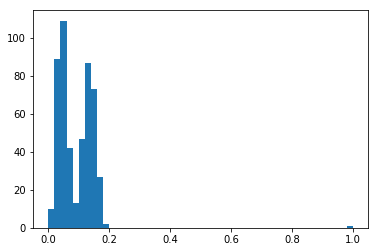

In [92]:
hist(Xnorm[:, 1], bins=50)
plt.show()

**Q:** Kako radi ovo skaliranje? <br>
**Q:** Dobiveni histogrami su vrlo slični. U čemu je razlika? <br>

#### (c)

Proučite razred [`preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ ako su iste skalirane standardnim skaliranjem (ukupno dva histograma).

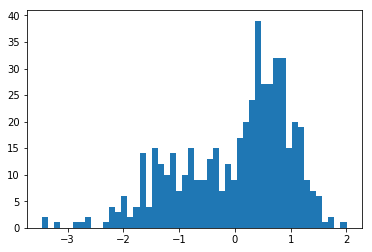

In [93]:
from sklearn.preprocessing import StandardScaler

Xnorm_std = StandardScaler().fit_transform(X)
hist(Xnorm_std[:, 0], bins=50)
plt.show()

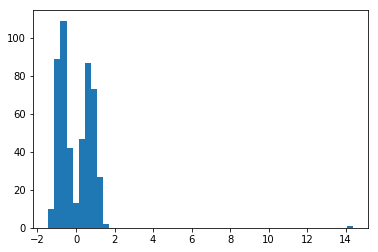

In [94]:
hist(Xnorm_std[:, 1], bins=50)
plt.show()

**Q:** Kako radi ovo skaliranje? <br>
**Q:** Dobiveni histogrami su vrlo slični. U čemu je razlika? <br>

#### (d)

Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1. Trenirajte SVM s jezgrenom funkcijom RBF na skupu za učenje i ispitajte točnost modela na skupu za ispitivanje, koristeći tri varijante gornjeg skupa: neskalirane značajke, standardizirane značajke i min-max skaliranje. Koristite podrazumijevane vrijednosti za $C$ i $\gamma$. Izmjerite točnost svakog od triju modela na skupu za učenje i skupu za ispitivanje. Ponovite postupak više puta (npr. 30) te uprosječite rezultate (u svakom ponavljanju generirajte podatke kao što je dano na početku ovog zadatka).

**NB:** Na skupu za učenje treba najprije izračunati parametre skaliranja te zatim primijeniti skaliranje (funkcija `fit_transform`), dok na skupu za ispitivanje treba samo primijeniti skaliranje s parametrima koji su dobiveni na skupu za učenje (funkcija `transform`).

In [95]:
def data_gen(iteration):
  X, y = make_classification(
    n_samples=500,
    n_features=2,
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1)
  X[:,1] = X[:,1]*100+1000
  X[0,1] = 3000
  return X, y

from collections import defaultdict
scores = defaultdict(list)

for X, y in map(data_gen, range(30)):
  Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.5)

  svm = SVC(kernel='rbf')
  scores['unscaled.test'].append(
    svm.fit(Xtrain, ytrain).score(Xtest, ytest))
  scores['unscaled.train'].append(
    svm.score(Xtrain, ytrain))
  
  minmax = MinMaxScaler()
  scores['minmax_scaled.test'].append(
    svm.fit(minmax.fit_transform(Xtrain), ytrain).score(
      minmax.transform(Xtest), ytest))
  scores['minmax_scaled.train'].append(
    svm.score(minmax.transform(Xtrain), ytrain))
  
  standard = StandardScaler()
  scores['standard_scaled.test'].append(
    svm.fit(standard.fit_transform(Xtrain), ytrain).score(
      standard.transform(Xtest), ytest))
  scores['standard_scaled.train'].append(
    svm.score(standard.transform(Xtrain), ytrain))
  
for k, v in scores.items():
  print(k, np.average(v))

unscaled.test 0.8421333333333333
unscaled.train 0.9846666666666665
minmax_scaled.test 0.894
minmax_scaled.train 0.9079999999999999
standard_scaled.test 0.9464000000000001
standard_scaled.train 0.9543999999999999


**Q:** Jesu li rezultati očekivani? Obrazložite. <br>
**Q:** Bi li bilo dobro kada bismo funkciju `fit_transform` primijenili na cijelom skupu podataka? Zašto? Bi li bilo dobro kada bismo tu funkciju primijenili zasebno na skupu za učenje i zasebno na skupu za ispitivanje? Zašto?

### 5. Algoritam k-najbližih susjeda

U ovom zadatku promatrat ćemo jednostavan klasifikacijski model imena **algoritam k-najbližih susjeda**. Najprije ćete ga samostalno isprogramirati kako biste se detaljno upoznali s radom ovog modela, a zatim ćete prijeći na analizu njegovih hiperparametara (koristeći ugrađeni razred, radi efikasnosti).

#### (a)

Implementirajte klasu `KNN`, koja implementira algoritam $k$ najbližih susjeda. Neobavezan parametar konstruktora jest broj susjeda `n_neighbours` ($k$), čija je podrazumijevana vrijednost 3. Definirajte metode `fit(X, y)` i `predict(X)`, koje služe za učenje modela odnosno predikciju. Kao mjeru udaljenosti koristite euklidsku udaljenost ([`numpy.linalg.norm`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html); pripazite na parametar `axis`). Nije potrebno implementirati nikakvu težinsku funkciju.

In [96]:
from numpy.linalg import norm
from collections import Counter

class KNN(object):
    def __init__(self, n_neighbors=3):
      self.k = n_neighbors

    def fit(self, X_train, y_train):
      self.xs = X_train
      self.ys = y_train
      return self

    def predict(self, X_test):
      ypreds = []
      for x in X_test:
        edist = lambda n: np.linalg.norm(x - n)
        nn_idxs = np.argsort([edist(x) for x in self.xs])[:self.k]
        class_ = Counter(self.ys[nn_idxs]).most_common(1)[0][0]
        ypreds.append(class_)
      return np.array(ypreds)

#### (b)

Kako biste se uvjerili da je Vaša implementacija ispravna, usporedite ju s onom u razredu [`neighbors.KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Budući da spomenuti razred koristi razne optimizacijske trikove pri pronalasku najboljih susjeda, obavezno postavite parametar `algorithm=brute`, jer bi se u protivnom moglo dogoditi da Vam se predikcije razlikuju. Usporedite modele na danom (umjetnom) skupu podataka (prisjetite se kako se uspoređuju polja; [`numpy.all`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.all.html)).

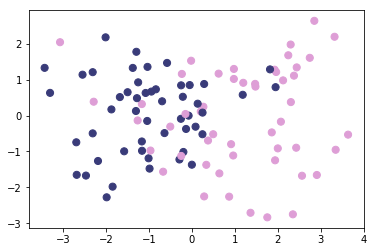

In [97]:
from sklearn.datasets import make_classification
X_art, y_art = make_classification(
  n_samples=100, n_features=2, n_classes=2, 
  n_redundant=0, n_clusters_per_class=2, 
  random_state=69)
mlutils.plot_2d_clf_problem(X_art, y_art)

In [98]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, algorithm='brute', metric='euclidean')\
  .fit(X_art, y_art)

In [99]:
knn.predict(X_art)

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0])

In [100]:
knn2 = KNN(n_neighbors=3).fit(X_art, y_art)
knn2.predict(X_art)

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0])

In [101]:
np.allclose(knn.predict(X_art), knn2.predict(X_art))

True

### 6. Analiza algoritma k-najbližih susjeda

Algoritam k-nn ima hiperparametar $k$ (broj susjeda). Taj hiperparametar izravno utječe na složenost algoritma, pa je stoga izrazito važno dobro odabrati njegovu vrijednost. Kao i kod mnogih drugih algoritama, tako i kod algoritma k-nn optimalna vrijednost hiperametra $k$ ovisi o konkretnom problemu, uključivo broju primjera $N$, broju značajki (dimenzija) $n$ te broju klasa $K$. 

Kako bismo dobili pouzdanije rezultate, potrebno je neke od eksperimenata ponoviti na različitim skupovima podataka i zatim uprosječiti dobivene vrijednosti pogrešaka. Koristite funkciju: `mlutils.knn_eval` koja trenira i ispituje model k-najbližih susjeda na ukupno `n_instances` primjera, i to tako da za svaku vrijednost hiperparametra iz zadanog intervala `k_range` ponovi `n_trials` mjerenja, generirajući za svako od njih nov skup podataka i dijeleći ga na skup za učenje i skup za ispitivanje. Udio skupa za ispitivanje definiran je parametrom `test_size`. Povratna vrijednost funkcije jest četvorka `(ks, best_k, train_errors, test_errors)`. Vrijednost `best_k` je optimalna vrijednost hiperparametra $k$ (vrijednost za koju je pogreška na skupu za ispitivanje najmanja). Vrijednosti `train_errors` i `test_errors`  liste su pogrešaka na skupu za učenja odnosno skupu za testiranje za sve razmatrane vrijednosti hiperparametra $k$, dok `ks` upravo pohranjuje sve razmatrane vrijednosti hiperparametra $k$.

#### (a)

Na podatcima iz zadatka 5, pomoću funkcije `mlutils.plot_2d_clf_problem` iscrtajte prostor primjera i područja koja odgovaraju prvoj odnosno drugoj klasi. Ponovite ovo za $k\in[1, 5, 20, 100]$. 

**NB:** Implementacija algoritma `KNeighborsClassifier` iz paketa `scikit-learn` vjerojatno će raditi brže od Vaše implementacije, pa u preostalim eksperimentima koristite nju.

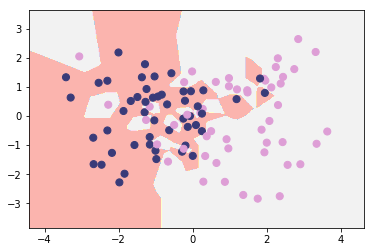

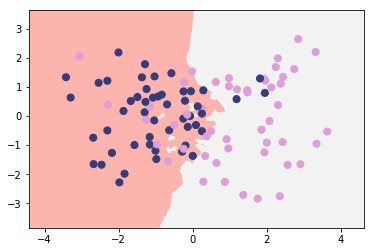

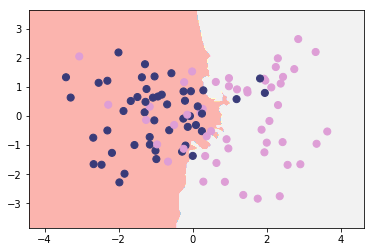

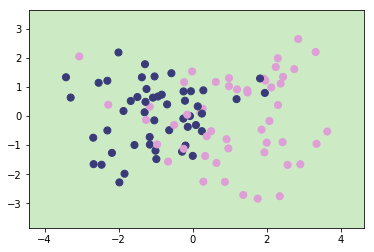

In [73]:
for k in (1, 5, 20, 100):
  knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')\
    .fit(X_art, y_art)
  mlutils.plot_2d_clf_problem(X_art, y_art, knn.predict)
  plt.show()

**Q:** Kako $k$ utječe na izgled granice između klasa?  
**Q:** Kako se algoritam ponaša u ekstremnim situacijama: $k=1$ i $k=100$?

#### (b)

Pomoću funkcije `mlutils.knn_eval`, iscrtajte pogreške učenja i ispitivanja kao funkcije hiperparametra $k\in\{1,\dots,20\}$, za $N=\{100, 500, 1000, 3000\}$ primjera. Načinite 4 zasebna grafikona (generirajte ih u 2x2 polju). U svakoj iteraciji ispišite optimalnu vrijednost hiperparametra $k$ (najlakše kao naslov grafikona; vidi [`plt.title`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.title.html)).

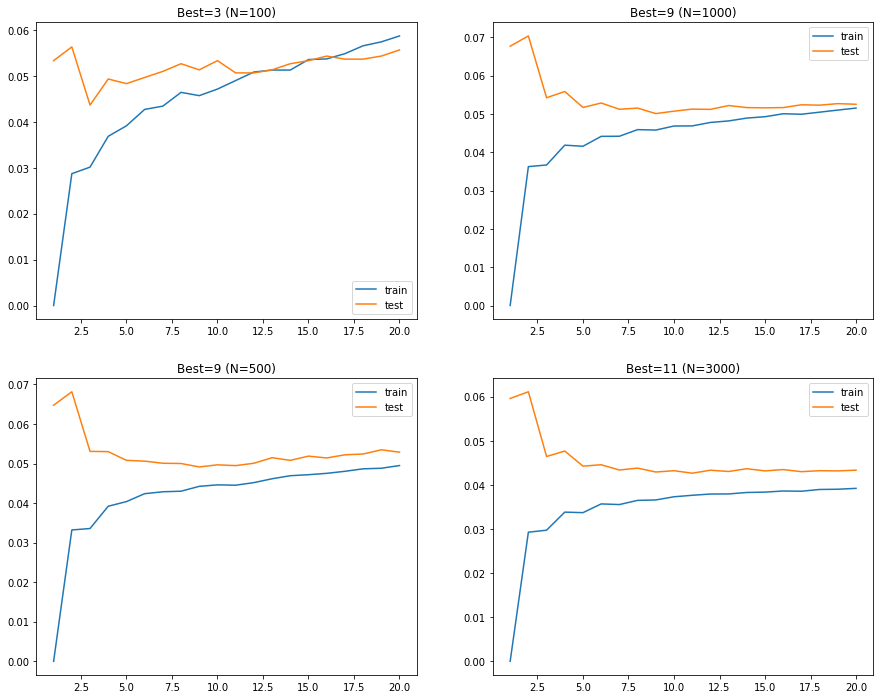

In [144]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, N in enumerate([100, 500, 1000, 3000]):
  ks, best_k, train_errors, test_errors = mlutils.knn_eval(
    n_instances=N, k_range=(1,20))
  
  j = 0 if i < 2 else 1
  axes[i % 2, j].plot(ks, train_errors, label='train')
  axes[i % 2, j].plot(ks, test_errors, label='test')
  axes[i % 2, j].set_title('Best=%d (N=%d)' % (best_k, N))
  axes[i % 2, j].legend()

plt.show()

**Q:** Kako se mijenja optimalna vrijednost hiperparametra $k$ s obzirom na broj primjera $N$? Zašto?  
**Q:** Kojem području odgovara prenaučenost, a kojem podnaučenost modela? Zašto?  
**Q:** Je li uvijek moguće doseći pogrešku od 0 na skupu za učenje?

#### (c)

Kako bismo provjerili u kojoj je mjeri algoritam k-najbližih susjeda osjetljiv na prisustvo nebitnih značajki, možemo iskoristiti funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) kako bismo generirali skup primjera kojemu su neke od značajki nebitne. Naime, parametar `n_informative` određuje broj bitnih značajki, dok parametar `n_features` određuje ukupan broj značajki. Ako je `n_features > n_informative`, onda će neke od značajki biti nebitne. Umjesto da izravno upotrijebimo funkciju `make_classification`, upotrijebit ćemo funkciju `mlutils.knn_eval`, koja samo preuzime ove parametre, ali nam omogućuje pouzdanije procjene.

Koristite funkciju `mlutils.knn_eval` na dva načina. U oba koristite $N=1000$ primjera, $n=10$ značajki i $K=5$ klasa, ali za prvi neka su svih 10 značajki bitne, a za drugi neka je bitno samo 5 od 10 značajki. Ispišite pogreške učenja i ispitivanja za oba modela za optimalnu vrijednost $k$ (vrijednost za koju je ispitna pogreška najmanja).

In [218]:
print('10 feats')
ks, best_k, train_errors, test_errors = mlutils.knn_eval(
  n_instances=1000, n_features=10, n_classes=5, n_informative=10)
print(
  'bestk=', best_k, 
  '\ntrainerr=', train_errors[best_k], 
  '\ntesterr=', test_errors[best_k])

print()
print('5 feats')
ks, best_k, train_errors, test_errors = mlutils.knn_eval(
  n_instances=1000, n_features=10, n_classes=5, n_informative=5)
print(
  'bestk=', best_k, 
  '\ntrainerr=', train_errors[best_k], 
  '\ntesterr=', test_errors[best_k])

10 feats
bestk= 9 
trainerr= 0.09568571428571432 
testerr= 0.13073333333333334

5 feats
bestk= 15 
trainerr= 0.16915714285714295 
testerr= 0.20446666666666657


**Q:** Je li algoritam k-najbližih susjeda osjetljiv na nebitne značajke? Zašto?  
**Q:** Je li ovaj problem izražen i kod ostalih modela koje smo dosad radili (npr. logistička regresija)?  
**Q:** Kako bi se model k-najbližih susjeda ponašao na skupu podataka sa značajkama različitih skala? Detaljno pojasnite.

### 7. "Prokletstvo dimenzionalnosti"

"Prokletstvo dimenzionalnosti" zbirni je naziv za niz fenomena povezanih s visokodimenzijskim prostorima. Ti fenomeni, koji se uglavnom protive našoj intuiciji, u većini slučajeva dovode do toga da se s porastom broja dimenzija (značajki) smanjenje točnost modela.

Općenito, povećanje dimenzija dovodi do toga da sve točke u ulaznome prostoru postaju (u smislu euklidske udaljenosti) sve udaljenije jedne od drugih te se, posljedično, gube razlike u udaljenostima između točaka. Eksperimentalno ćemo provjeriti da je to doista slučaj. Proučite funkciju [`metrics.pairwise.pairwise_distances`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html). Generirajte 100 slučajnih vektora u različitim dimenzijama $n\in[1,2,\ldots,50]$ dimenzija te izračunajte *prosječnu* euklidsku udaljenost između svih parova tih vektora. Za generiranje slučajnih vektora koristite funkciju [`numpy.random.random`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.random.html). Na istom grafu skicirajte krivulje prosječnih udaljenosti za euklidsku i kosinusnu udaljenost (parametar `metric`).

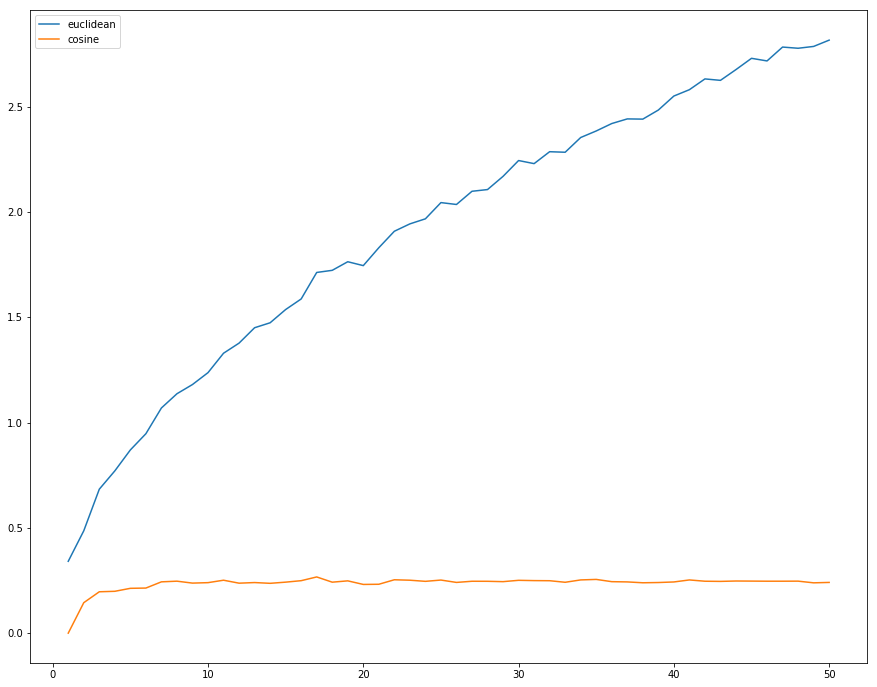

In [108]:
from sklearn.metrics import pairwise_distances
from numpy.random import random

euclideans, cosines = [], []
for D in range(1, 51):
  xs = np.random.random(size=(100, D))
  euclideans.append(np.average(pairwise_distances(xs, metric='euclidean')))
  cosines.append(np.average(pairwise_distances(xs, metric='cosine')))

plt.figure(figsize=(15,12))
plt.plot(list(range(1, 51)), euclideans, label='euclidean')
plt.plot(list(range(1, 51)), cosines, label='cosine')
plt.legend()
plt.show()

**Q:** Pokušajte objasniti razlike u rezultatima. Koju biste od ovih dviju mjera koristili za klasifikaciju visokodimenzijskih podataka?  
**Q:** Zašto je ovaj problem osobito izražen kod algoritma k-najbližih susjeda?